In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


                    mean      variance           std
Eco1        1.608159e+04  3.896715e+08  1.974010e+04
Eco2        1.563012e+04  1.436997e+08  1.198748e+04
Eco3        2.154380e+04  3.392410e+08  1.841850e+04
Energy1     5.190460e+01  5.670438e+02  2.381268e+01
Energy2     8.518011e+01  7.069737e+02  2.658898e+01
Energy3     9.122605e+01  2.653917e+03  5.151618e+01
Health1     2.719460e+01  1.068251e+03  3.268411e+01
Health2     2.639169e+00  1.961718e+00  1.400614e+00
Finan1      4.083050e-01  6.537267e-02  2.556808e-01
Finan2      4.849812e+06  1.299377e+14  1.139902e+07
Finan3      6.034541e-01  8.103563e-02  2.846676e-01
Finan4      2.719485e+00  4.953787e-01  7.038315e-01
Finan5      6.428665e-01  5.486216e-02  2.342267e-01
Governance  2.015184e-01  8.681570e-01  9.317494e-01
Poverty     2.653826e+01  3.945067e+02  1.986219e+01
Env         4.891840e+00  2.955839e+01  5.436763e+00
Other1      5.089391e+00  4.615744e+01  6.793927e+00
Other2      1.497062e+01  2.397513e+02  1.5483

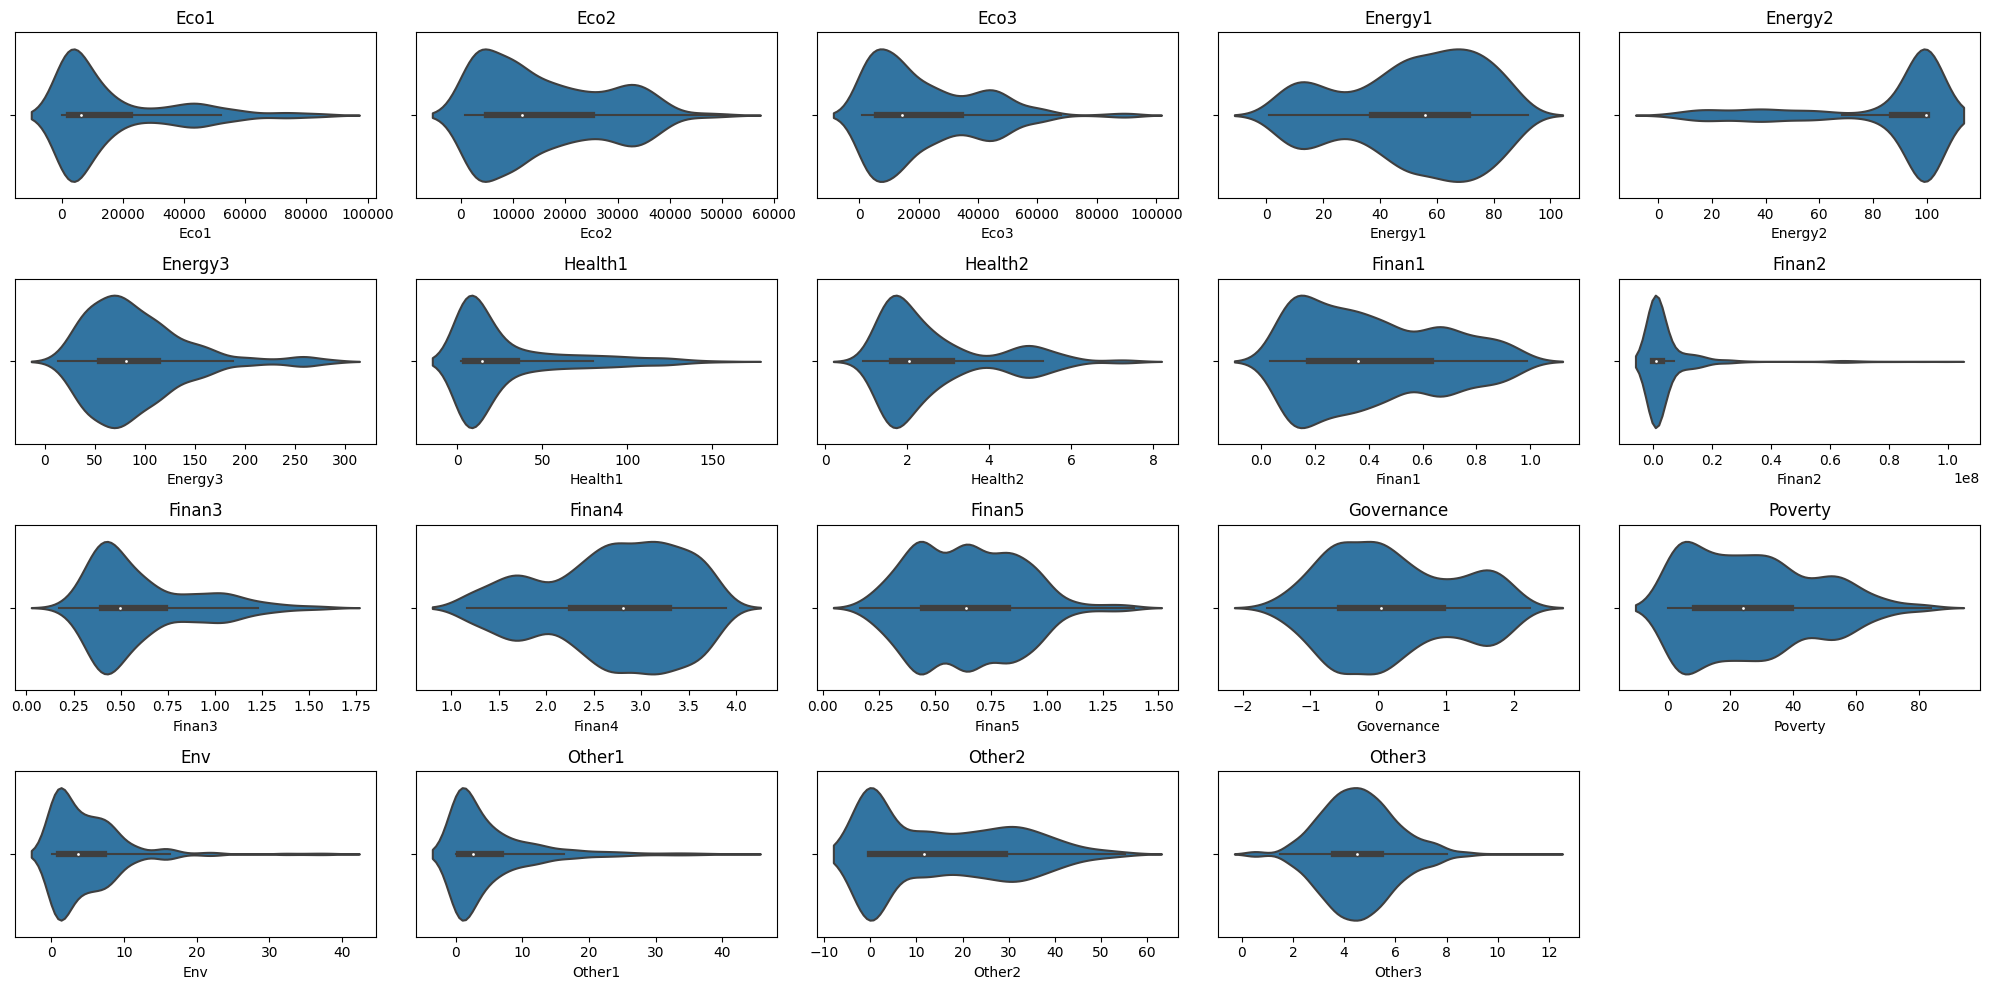

In [4]:
# Load the dataset
file_path = 'Income_Inequality.csv'
data = pd.read_csv(file_path, delimiter=';')
# Compute the descriptive statistics for the quantitative variables
# Exclude 'Country', 'Year', and 'Income_Inequality' columns
quantitative_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop(['Country', 'Year'])
descriptive_stats = data[quantitative_columns].agg(['mean', 'var', 'std']).transpose()
descriptive_stats.rename(columns={'var': 'variance'}, inplace=True)

print(descriptive_stats)

# Check for missing values
missing_values = data[quantitative_columns].isnull().sum()

# Plot violin plots for the quantitative variables
plt.figure(figsize=(20,10))
for i, col in enumerate(quantitative_columns, 1):
    plt.subplot(4, 5, i)
    sns.violinplot(data=data, x=col)
    plt.title(col)

plt.tight_layout()
#plt.show()

In [5]:
# Encode the target variable 'Income_Inequality' where 'H' is 1 and 'L' is 0
label_encoder = LabelEncoder()
data['Income_Inequality'] = label_encoder.fit_transform(data['Income_Inequality'])

# Separate the features and the target
X = data.drop([ 'Country','Year','Income_Inequality'], axis=1)
y = data['Income_Inequality']

# Split the data into a training set and a test set with a test size of 30%
# We use random_state to ensure reproducibility which is equivalent to set.seed in R
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [6]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 100,9),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'ccp_alpha': [0,0.00001,0.0001,0.001]  # Add a range for ccp_alpha
}


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# The best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 2816 candidates, totalling 14080 fits


In [8]:
# Train the model with the best hyperparameters
optimized_tree = grid_search.best_estimator_

# Predict on the test set with the optimized model
y_pred_optimized = optimized_tree.predict(X_test)

# A. Detailed Accuracy By Class
# Calculate the accuracy with the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

print(best_params, best_score, accuracy_optimized, classification_rep_optimized)

# B. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_optimized)

# C. Additional metrics
# Precision, recall, and f1-scores for each class
precision_class_0 = precision_score(y_test, y_pred_optimized, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_optimized, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred_optimized, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred_optimized, pos_label=1)
f1_score_class_0 = f1_score(y_test, y_pred_optimized, pos_label=0)
f1_score_class_1 = f1_score(y_test, y_pred_optimized, pos_label=1)

# Compile all the additional metrics into a dictionary for presentation
additional_metrics = {
    'Precision Class 0': precision_class_0,
    'Precision Class 1': precision_class_1,
    'Recall Class 0': recall_class_0,
    'Recall Class 1': recall_class_1,
    'F1 Score Class 0': f1_score_class_0,
    'F1 Score Class 1': f1_score_class_1,
}

print(conf_mat)
print(additional_metrics)

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7} 0.9409158650589351 0.9616858237547893               precision    recall  f1-score   support

           0       0.97      0.98      0.97       171
           1       0.95      0.93      0.94        90

    accuracy                           0.96       261
   macro avg       0.96      0.95      0.96       261
weighted avg       0.96      0.96      0.96       261

[[167   4]
 [  6  84]]
{'Precision Class 0': 0.9653179190751445, 'Precision Class 1': 0.9545454545454546, 'Recall Class 0': 0.9766081871345029, 'Recall Class 1': 0.9333333333333333, 'F1 Score Class 0': 0.9709302325581396, 'F1 Score Class 1': 0.9438202247191012}


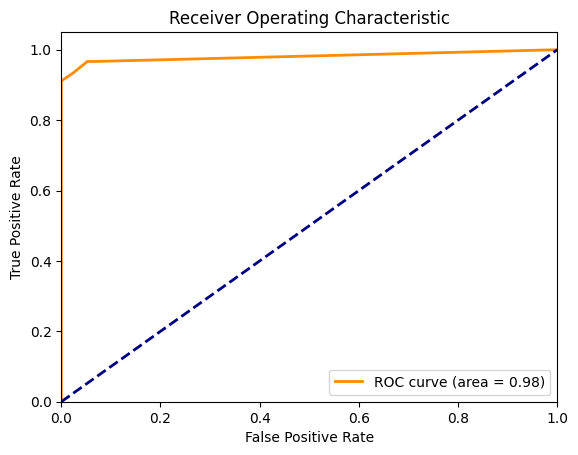

AUC: 0.98


In [18]:
# Compute the predicted probabilities of class 1 for the test set
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Compute TPR and FPR for various threshold settings
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print the AUC
print('AUC: %0.2f' % roc_auc)


On observe d'excellents résultats certainement dûs à la rigeur du grid et de la cross validation. Uu tres bon f1 score traduit une performance équilibré pour les differentes classe. La courbe ROC est aussi très encourageante!

In [31]:
# Initialisation de la forêt d'isolement avec les hyperparamètres spécifiés
iso_forest = IsolationForest(n_estimators=100, random_state=1234)

# Ajustement de la forêt d'isolement à l'ensemble complet des données.
iso_forest.fit(X)

# Calcul des scores d'anomalie pour chaque observation.
anomaly_scores = iso_forest.decision_function(X)

# Ajout des scores d'anomalie au DataFrame original.
data['AnomalyScore'] = anomaly_scores

# Tri des données par les scores d'anomalie pour trouver les plus élevés et les plus bas.
highest_anomalies = data.nlargest(10, 'AnomalyScore')
lowest_anomalies = data.nsmallest(10, 'AnomalyScore')

# Tri des données par les scores d'anomalie pour trouver les plus élevés et les plus bas.
highest_anomaly_scores = data.nlargest(10, 'AnomalyScore')['AnomalyScore']
lowest_anomaly_scores = data.nsmallest(10, 'AnomalyScore')['AnomalyScore']

highest_anomaly_scores, lowest_anomaly_scores

(94     0.118808
 90     0.115175
 95     0.114831
 93     0.114079
 196    0.113981
 195    0.113651
 199    0.112472
 629    0.111926
 198    0.111326
 336    0.110913
 Name: AnomalyScore, dtype: float64,
 671   -0.113272
 672   -0.112261
 673   -0.111429
 670   -0.092140
 674   -0.090403
 675   -0.077090
 0     -0.068277
 677   -0.066479
 573   -0.066351
 571   -0.065978
 Name: AnomalyScore, dtype: float64)

In [44]:
# Charger les données depuis le fichier fourni
file_path = 'Income_Inequality.csv'
data = pd.read_csv(file_path, delimiter=';')

# Encodage de la variable cible 'Income_Inequality' où 'H' est 1 et 'L' est 0
label_encoder = LabelEncoder()
data['Income_Inequality'] = label_encoder.fit_transform(data['Income_Inequality'])

# Séparation des caractéristiques et de la cible
X = data.drop(['Country', 'Year', 'Income_Inequality'], axis=1)
y = data['Income_Inequality']

# Division des données en ensembles d'entraînement et de test avec une taille de test de 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
print(X_train.shape, y_train.shape)
# Calcul des scores d'anomalie pour l'ensemble de données complet
iso_forest = IsolationForest(random_state=1234)
iso_forest.fit(X)

# Calcul des scores d'anomalie pour chaque observation
anomaly_scores = iso_forest.decision_function(X)
data['AnomalyScore'] = anomaly_scores  # Ajout des scores d'anomalie au DataFrame original

# Identification des indices des 50 plus grandes anomalies dans l'ensemble de données complet
top_50_anomalies_indices = data['AnomalyScore'].nsmallest(50).index

# Nous devons maintenant vérifier quels de ces indices appartiennent à l'ensemble d'entraînement
train_indices = X_train.index
top_50_anomalies_train_indices = top_50_anomalies_indices.intersection(train_indices)

# Retrait des 50 plus grandes anomalies des ensembles d'entraînement
X_train = X_train.drop(index=top_50_anomalies_train_indices)
y_train = y_train.drop(index=top_50_anomalies_train_indices)

# Vérification des dimensions après retrait
X_train.shape, y_train.shape, top_50_anomalies_train_indices


(609, 19) (609,)


((572, 19),
 (572,),
 Index([671, 673, 674, 675,   0, 677, 573, 571,  50,   1, 574, 678, 676, 572,
          2, 848, 575, 841,   3, 847, 843, 846,  52, 603, 601, 608, 101, 103,
        141, 561, 720, 142,  54, 102, 600,  53,  56],
       dtype='int64'))

In [38]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 100,9),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'ccp_alpha': [0,0.00001,0.0001,0.001]  # Add a range for ccp_alpha
}


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV


# Initialize the GridSearchCV object with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1234), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# The best hyperparameters from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 2816 candidates, totalling 14080 fits


In [39]:
# Train the model with the best hyperparameters
optimized_tree = grid_search.best_estimator_

# Predict on the test set with the optimized model
y_pred_optimized = optimized_tree.predict(X_test)

# A. Detailed Accuracy By Class
# Calculate the accuracy with the optimized model
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
classification_rep_optimized = classification_report(y_test, y_pred_optimized)

print(best_params, best_score, accuracy_optimized, classification_rep_optimized)

# B. Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred_optimized)

# C. Additional metrics
# Precision, recall, and f1-scores for each class
precision_class_0 = precision_score(y_test, y_pred_optimized, pos_label=0)
precision_class_1 = precision_score(y_test, y_pred_optimized, pos_label=1)
recall_class_0 = recall_score(y_test, y_pred_optimized, pos_label=0)
recall_class_1 = recall_score(y_test, y_pred_optimized, pos_label=1)
f1_score_class_0 = f1_score(y_test, y_pred_optimized, pos_label=0)
f1_score_class_1 = f1_score(y_test, y_pred_optimized, pos_label=1)

# Compile all the additional metrics into a dictionary for presentation
additional_metrics = {
    'Precision Class 0': precision_class_0,
    'Precision Class 1': precision_class_1,
    'Recall Class 0': recall_class_0,
    'Recall Class 1': recall_class_1,
    'F1 Score Class 0': f1_score_class_0,
    'F1 Score Class 1': f1_score_class_1,
}

print(conf_mat)
print(additional_metrics)

{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7} 0.9409158650589351 0.9616858237547893               precision    recall  f1-score   support

           0       0.97      0.98      0.97       171
           1       0.95      0.93      0.94        90

    accuracy                           0.96       261
   macro avg       0.96      0.95      0.96       261
weighted avg       0.96      0.96      0.96       261

[[167   4]
 [  6  84]]
{'Precision Class 0': 0.9653179190751445, 'Precision Class 1': 0.9545454545454546, 'Recall Class 0': 0.9766081871345029, 'Recall Class 1': 0.9333333333333333, 'F1 Score Class 0': 0.9709302325581396, 'F1 Score Class 1': 0.9438202247191012}


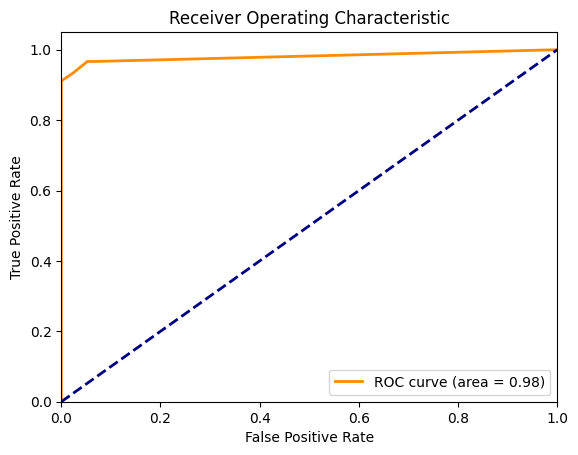

AUC: 0.98


In [40]:
# Compute the predicted probabilities of class 1 for the test set
y_pred_prob = optimized_tree.predict_proba(X_test)[:, 1]

# Compute TPR and FPR for various threshold settings
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print the AUC
print('AUC: %0.2f' % roc_auc)


 La standardisation des données est cruciale car les variables ont des échelles différentes ou des unités de mesure différentes. Si une variable est mesurée à une échelle beaucoup plus grande que les autres, elle dominera la première composante principale et, par conséquent, biaiserait le résultat de l'ACP. La standardisation transforme les données de sorte que chaque variable ait une moyenne de 0 et un écart-type de 1, ce qui permet de traiter toutes les variables de manière égale dans l'analyse.

In [ ]:
# Initialisation du StandardScaler
scaler = StandardScaler()

# Standardisation des ensembles d'entraînement et de test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Les données standardisées sont maintenant dans des arrays NumPy, nous pouvons les convertir en DataFrame pour une meilleure lisibilité si nécessaire
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

Variance expliquée par chaque composante principale: [9.99991734e-01 7.96810425e-06]


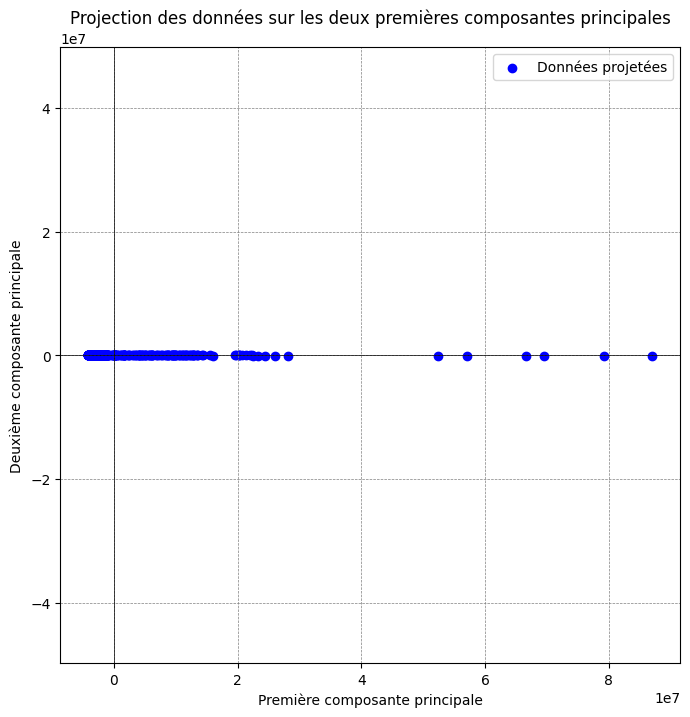

Qualité de la représentation des individus (cos2) sur les axes (premiers individus) :
[[3.15776013e-04 1.37224190e-03]
 [1.47169315e-04 3.22511568e-05]
 [3.51934298e-04 1.10670889e-03]
 [3.10415953e-04 1.40667117e-03]
 [2.92702786e-03 2.88069412e-03]]
Contribution des individus aux axes (premiers individus) :
[[3.15223957e-04 1.36984287e-03]
 [1.46912026e-04 3.21947737e-05]
 [3.51319028e-04 1.10477409e-03]
 [3.09873268e-04 1.40421195e-03]
 [2.92191068e-03 2.87565794e-03]]


In [50]:

# Initialisation de l'ACP avec 2 composantes principales
pca = PCA(n_components=2)

# Ajustement de l'ACP sur les données d'entraînement standardisées
pca.fit(X_train)

# Transformation des données d'entraînement et de test
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Affichage de la variance expliquée par chaque composante principale
explained_variance = pca.explained_variance_ratio_

# Affichage des résultats
print("Variance expliquée par chaque composante principale:", explained_variance)

# Création du graphique pour les deux premières composantes principales
plt.figure(figsize=(8, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], color='blue', label='Données projetées')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('Projection des données sur les deux premières composantes principales')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.legend()
plt.axis('equal')
plt.show()

# On va également calculer la qualité des représentations et les contributions comme dans l'exemple manuel
# Qualité de la représentation des individus sur les axes
cos2 = X_train_pca ** 2
for i in range(X_train_pca.shape[1]):
    cos2[:, i] = cos2[:, i] / np.sum(X_train_pca[:, i] ** 2)

# Contributions des individus aux axes
contrib = X_train_pca ** 2
for i in range(X_train_pca.shape[1]):
    contrib[:, i] = contrib[:, i] / (X_train_pca.shape[0] * pca.explained_variance_[i])

# Affichage de la qualité de représentation sur les axes pour les premiers individus
print("Qualité de la représentation des individus (cos2) sur les axes (premiers individus) :")
print(cos2[:5])

# Affichage des contributions aux axes pour les premiers individus
print("Contribution des individus aux axes (premiers individus) :")
print(contrib[:5])


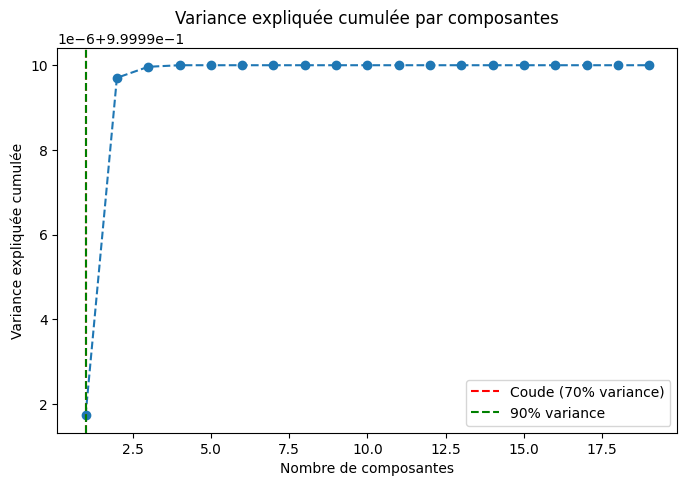

IndexError: index 1 is out of bounds for axis 1 with size 1

<Figure size 800x800 with 0 Axes>

In [53]:
# Nous allons d'abord ajuster une ACP sans réduction pour déterminer le nombre de composantes nécessaires 
# afin d'expliquer un certain pourcentage de la variance totale.

# Initialisation de l'ACP sans réduction de dimension
pca_full = PCA()

# Ajustement de l'ACP sur les données d'entraînement standardisées
pca_full.fit(X_train)

# Calcul de la variance expliquée cumulée
cumulative_explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Détermination de la dimension k pour différentes règles
# Règle du coude : trouver un 'coude' dans la courbe de variance expliquée cumulée
k_elbow = np.argmax(cumulative_explained_variance >= 0.7) + 1  # Exemple avec 70% de variance expliquée

# Règle de Kaiser : garder les composantes avec une variance supérieure à la moyenne
k_kaiser = np.sum(pca_full.explained_variance_ >= 1)

# Autres règles pourraient inclure le nombre de composantes pour atteindre 80%, 90%, 95%, etc. de la variance expliquée.
# Par exemple, avec 90% de variance expliquée :
k_90_percent = np.argmax(cumulative_explained_variance >= 0.9) + 1

# Réduction de dimension avec la règle du coude (ou autre règle choisie)
pca_reduced = PCA(n_components=k_elbow)
X_train_pca_reduced = pca_reduced.fit_transform(X_train)

# Visualisation de la variance expliquée cumulée pour aider à la décision
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance)+1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Variance expliquée cumulée par composantes')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.axvline(x=k_elbow, color='red', linestyle='--', label='Coude (70% variance)')
plt.axvline(x=k_90_percent, color='green', linestyle='--', label='90% variance')
plt.legend()
plt.show()

# Visualisation du nuage des n points dans les premiers plans factoriels
colors = ['red' if label == 1 else 'blue' for label in y_train]
plt.figure(figsize=(8, 8))
plt.scatter(X_train_pca_reduced[:, 0], X_train_pca_reduced[:, 1], color=colors, alpha=0.5)
plt.title('Nuage des points dans le premier plan factoriel (ACP réduite)')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.grid(True)
plt.show()

# Résultats pour la dimension de réduction retenue
k_elbow, k_kaiser, k_90_percent
